In [9]:
# ---  論文の手法  ---
# ライブラリのインポート
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial, Gaussian, NegativeBinomial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

In [10]:
# 1. データ読み込み
df = pd.read_excel('kadai.xlsx')

df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

train = df[:1776]
test = df[1776:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train = train[train["final_mes_time"] < test['process_end_time'][0]]

target = 'OV'
features = [c for c in train.columns if c.startswith('X')]

In [32]:
# 標準化
exclude_cols = ['process_end_time', 'final_mes_time', 'OV']

feature_cols = [c for c in train.columns if c not in exclude_cols]

scaler = StandardScaler()

scaler.fit(train[feature_cols])

train_scaled_vals = scaler.transform(train[feature_cols])
test_scaled_vals = scaler.transform(test[feature_cols])

train_features_df = pd.DataFrame(train_scaled_vals, columns=feature_cols, index=train.index)
test_features_df = pd.DataFrame(test_scaled_vals, columns=feature_cols, index=test.index)

train = pd.concat([train[exclude_cols], train_features_df], axis=1)
test = pd.concat([test[exclude_cols], test_features_df], axis=1)

print("標準化完了。")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\n確認(X1の平均):", train['X1'].mean()) 

標準化完了。
Train shape: (1155, 86)
Test shape: (500, 86)

確認(X1の平均): -3.691131094857663e-17


In [33]:
# 2. 変数選択関数(ステップワイズAIC)
def stepwise_selection(X, y, initial_list=[], verbose=False):
    included = list(initial_list)

    if not included:
        current_aic = float('inf')
    else:
        model = sm.GLM(y, sm.add_constant(X[included]), family=NegativeBinomial()).fit()
        current_aic = model.aic

    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_aic = pd.Series(index=excluded, dtype='float64')
        
        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(X[included + [new_column]]), family=NegativeBinomial()).fit()
            new_aic[new_column] = model.aic
            
        if not new_aic.empty:
            best_aic = new_aic.min()
            if best_aic < current_aic:
                best_feature = new_aic.idxmin()
                included.append(best_feature)
                current_aic = best_aic
                changed = True

        if included:
            worst_aic = pd.Series(index=included, dtype='float64')
            for remove_column in included:
                try_included = list(included)
                try_included.remove(remove_column)

                if not try_included:
                    worst_aic[remove_column] = float('inf')
                else:
                    model = sm.GLM(y, sm.add_constant(X[try_included]), family=NegativeBinomial()).fit()
                    worst_aic[remove_column] = model.aic
            
            best_aic_after_remove = worst_aic.min()

            if best_aic_after_remove < current_aic:
                worst_feature = worst_aic.idxmin()
                included.remove(worst_feature)
                current_aic = best_aic_after_remove
                changed = True
        
        if not changed:
            break
            
    return included

In [29]:
# 2. 変数選択関数(回帰木)
def DecisionTreeSelector(x, y, depth=7, threshold='mean', max_features=10):
    reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    reg.fit(x, y)

    selector = SelectFromModel(reg, prefit=True, threshold=threshold, max_features=max_features)

    selected_mask = selector.get_support()
    selected_features = x.columns[selected_mask].tolist()

    if len(selected_features) == 0:
        feature_importances = pd.Series(reg.feature_importances_, index=x.columns)
        selected_features = feature_importances.nlargest(max_features).index.tolist()

    return selected_features

最適なホッケースティック分割変数を探索中...
探索対象特徴量数: 83

[成功] 最適分割発見: X31 < -0.4105 (AIC: 21004.90)
決定された分割変数: X31
決定された閾値: -0.41052149792879444


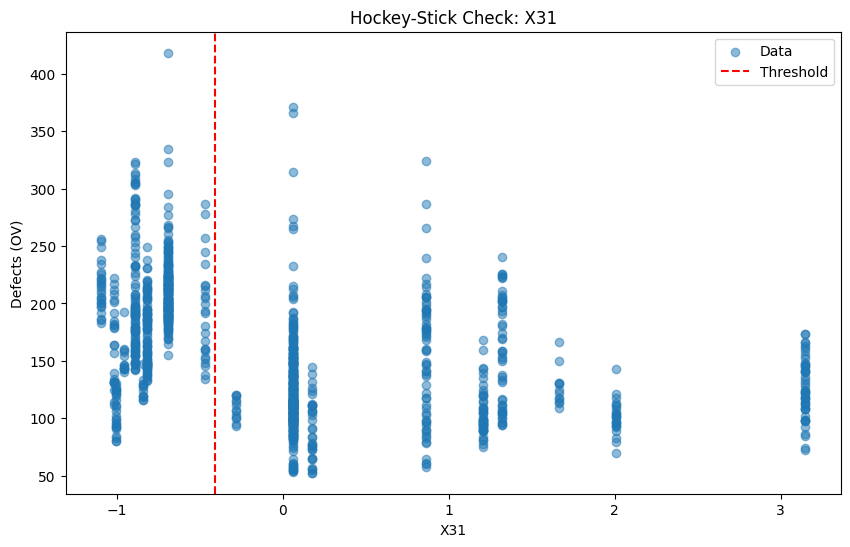

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson

# ---------------------------------------------------------
# 1. 改良版 探索関数
# ---------------------------------------------------------
def find_best_hockey_stick_split(X, y, features, verbose=False):
    """
    全特徴量を探索し、ポアソンGLMを用いたホッケースティック回帰で
    最もAICを下げる「分割変数」と「閾値」を見つける関数 (Debug版)
    """
    best_aic = float('inf')
    best_feature = None
    best_threshold = None
    
    # 目的変数のチェック
    if y.isnull().any():
        print("警告: 目的変数(OV)に欠損値が含まれています。削除してから実行してください。")
        return None, None
    if (y < 0).any():
        print("警告: 目的変数(OV)に負の値が含まれています。ポアソン回帰は適用できません。")
        return None, None

    print(f"探索対象特徴量数: {len(features)}")
    
    # エラーカウント用
    error_counts = {}

    for i, feature in enumerate(features):
        # 進捗表示 (任意)
        # if i % 10 == 0: print(f"Processing {feature}...")
        
        # 閾値候補の生成（データの分布に基づく）
        # データのばらつきが極端に少ない場合はスキップ
        if X[feature].nunique() < 5:
            continue
            
        thresholds = np.percentile(X[feature], np.arange(10, 91, 5))
        unique_thresholds_list = sorted(list(set(thresholds)))
        
        for thresh in unique_thresholds_list:
            mask_stable = X[feature] < thresh
            mask_unstable = X[feature] >= thresh
            
            # データ数が少なすぎる場合はスキップ
            if mask_stable.sum() < 10 or mask_unstable.sum() < 10:
                continue
            
            # 分散チェック (定数値になっていないか)
            # 定数値だと「行列が特異(Singular Matrix)」エラーになるため
            if X.loc[mask_stable, feature].std() == 0 or X.loc[mask_unstable, feature].std() == 0:
                continue

            try:
                # 安定領域モデル
                X_stable = sm.add_constant(X.loc[mask_stable, [feature]])
                model_stable = sm.GLM(y[mask_stable], X_stable, family=Poisson()).fit()
                
                # 不安定領域モデル
                X_unstable = sm.add_constant(X.loc[mask_unstable, [feature]])
                model_unstable = sm.GLM(y[mask_unstable], X_unstable, family=Poisson()).fit()
                
                # 合計AIC
                total_aic = model_stable.aic + model_unstable.aic
                
                if total_aic < best_aic:
                    best_aic = total_aic
                    best_feature = feature
                    best_threshold = thresh
                    
            except Exception as e:
                # エラー内容を記録（最初の1回だけ表示するなど制御可能）
                err_msg = str(e)
                error_counts[err_msg] = error_counts.get(err_msg, 0) + 1
                if verbose and error_counts[err_msg] == 1:
                    print(f"Error at {feature} < {thresh:.4f}: {e}")
                continue

    # 探索終了後のレポート
    if best_feature is None:
        print("\n[失敗] 有効な分割が見つかりませんでした。")
        print("主なエラー原因内訳:")
        for msg, count in list(error_counts.items())[:5]:
            print(f"- {msg}: {count}回")
    else:
        print(f"\n[成功] 最適分割発見: {best_feature} < {best_threshold:.4f} (AIC: {best_aic:.2f})")

    return best_feature, best_threshold

# ---------------------------------------------------------
# 2. 実行部分
# ---------------------------------------------------------
# ノートブックの変数をそのまま使用
# train は標準化済みの説明変数を含んでいる前提

print("最適なホッケースティック分割変数を探索中...")

# trainデータフレームから説明変数の部分だけを抽出して渡す
# (train[features] で取得可能)
best_split_feature, best_threshold = find_best_hockey_stick_split(
    train[features],  # X
    train[target],    # y
    features,
    verbose=True      # エラー詳細を表示
)

# ---------------------------------------------------------
# 3. 結果の確認と可視化 (Noneチェック付き)
# ---------------------------------------------------------
if best_split_feature is not None:
    print(f"決定された分割変数: {best_split_feature}")
    print(f"決定された閾値: {best_threshold}")
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(train[best_split_feature], train[target], alpha=0.5, label='Data')
    plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold')
    plt.title(f"Hockey-Stick Check: {best_split_feature}")
    plt.xlabel(best_split_feature)
    plt.ylabel("Defects (OV)")
    plt.legend()
    plt.show()
    
    # --- ここから予測モデルの再構築へ進む ---
    # 分割基準がNoneでない場合のみ、後続の回帰木変数選択などの処理を実行してください
else:
    print("分割変数が決定できなかったため、グラフ描画と後続処理をスキップします。")
    print("データの分布や前処理（欠損値、スケーリング、目的変数の値）を再確認してください。")

In [37]:
if best_threshold is not None:
    print(f"決定された分割基準: {best_split_feature} < {best_threshold:.4f} で安定領域判定")

    train_stable = train[train[best_split_feature] < best_threshold]
    train_unstable = train[train[best_split_feature] >= best_threshold]

    print("\n回帰木による変数選択を実行中...")
    selected_dt_stable = DecisionTreeSelector(train_stable[features], train_stable[target])
    selected_dt_unstable = DecisionTreeSelector(train_unstable[features], train_unstable[target])

    print("\nステップワイズAICによる変数選択を実行中...")
    selected_vars_stable = stepwise_selection(train_stable[selected_dt_stable], train_stable[target])
    selected_vars_unstable = stepwise_selection(train_unstable[selected_dt_unstable], train_unstable[target])

    if best_split_feature not in selected_vars_stable:
        selected_vars_stable.append(best_split_feature)
    if best_split_feature not in selected_vars_unstable:
        selected_vars_unstable.append(best_split_feature)

    selected_vars_stable = list(dict.fromkeys(selected_vars_stable))
    selected_vars_unstable = list(dict.fromkeys(selected_vars_unstable))

    print(f"安定モデル採用変数: {selected_vars_stable}")
    print(f"不安定モデル採用変数: {selected_vars_unstable}")

    X_train_stable = sm.add_constant(train_stable[selected_vars_stable], has_constant='add')
    model_stable = sm.GLM(train_stable[target], X_train_stable, family=NegativeBinomial()).fit()

    X_train_unstable = sm.add_constant(train_unstable[selected_vars_unstable], has_constant='add')
    model_unstable = sm.GLM(train_unstable[target], X_train_unstable, family=NegativeBinomial()).fit()

    test_X_stable = sm.add_constant(test[selected_vars_stable], has_constant='add')
    test_X_unstable = sm.add_constant(test[selected_vars_unstable], has_constant='add')

    pred_stable_all = model_stable.predict(test_X_stable)
    pred_unstable_all = model_unstable.predict(test_X_unstable)

    final_predictions = np.where(
        test[best_split_feature] < best_threshold,
        pred_stable_all,
        pred_unstable_all
    )

    test['Prediction'] = final_predictions

    print("\n予測完了。")
    final_rmse = np.sqrt(mean_squared_error(test[target], test['Prediction']))
    print(f"最終テストRMSE: {final_rmse:.4f}")
    print(test[['Prediction']].head())

else:
    print("有効な結果が得られませんでした。")

決定された分割基準: X31 < -0.4105 で安定領域判定

回帰木による変数選択を実行中...

ステップワイズAICによる変数選択を実行中...
安定モデル採用変数: ['X34', 'X37', 'X31']
不安定モデル採用変数: ['X60', 'X38', 'X30', 'X31']

予測完了。
最終テストRMSE: 101.9423
   Prediction
0  186.000873
1  186.000873
2  186.000873
3  186.000873
4  186.000873


最終テストデータのRMSE: 101.9423


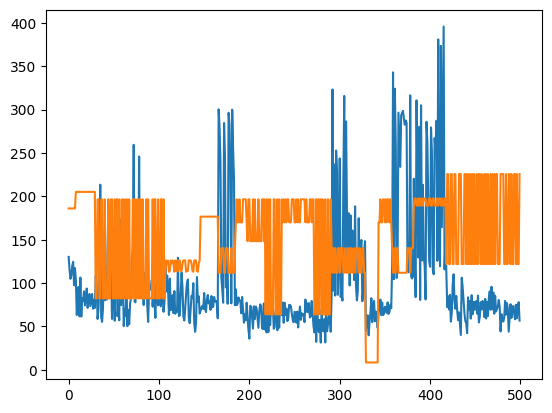

In [38]:
# 精度評価
y_true = test['OV']
y_pred = test['Prediction']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=" * 30)
print(f"最終テストデータのRMSE: {rmse:.4f}")
print("=" * 30)

plt.plot(y_true)
plt.plot(y_pred, linestyle='-')
plt.show()

ポアソン基準での最適分割を探索中...
決定された分割変数: X31
決定された閾値: -0.4105


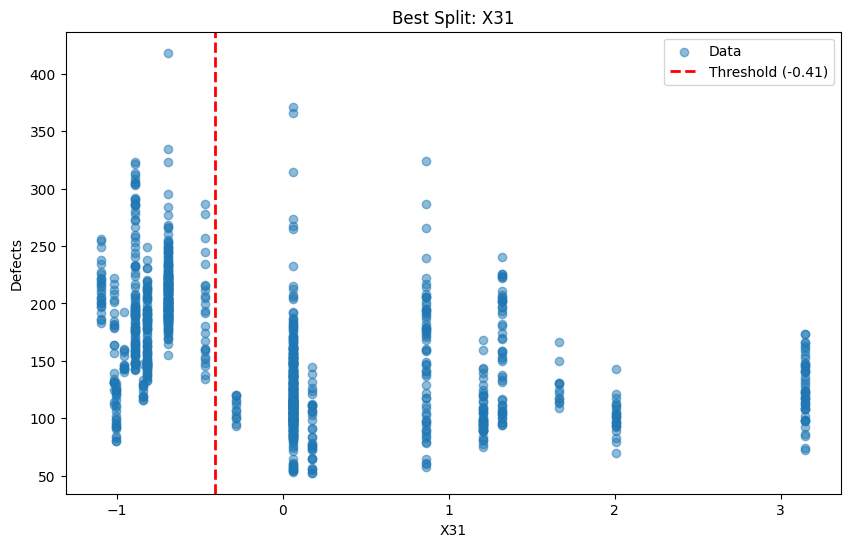

In [40]:
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson

def poisson_deviance(y_true, y_pred):
    # ポアソン偏差の計算式: 2 * sum(y_true * log(y_true/y_pred) - (y_true - y_pred))
    # 0除算回避のため微小値を加える
    y_pred = np.maximum(y_pred, 1e-6)
    term1 = y_true * np.log(y_true / y_pred + 1e-6)
    term2 = y_true - y_pred
    # y_trueが0の部分のlog計算対策
    term1 = np.where(y_true == 0, 0, term1)
    return 2 * np.sum(term1 - term2)

def find_best_poisson_split(df, target_col, feature_cols):
    best_score = float('inf')
    best_feature = None
    best_threshold = None
    
    y = df[target_col].values
    
    # 全変数をループ
    for feature in feature_cols:
        x = df[feature].values
        
        # 探索する閾値の候補（データの10%〜90%の範囲にあるユニークな値）
        thresholds = np.unique(np.percentile(x, np.arange(10, 91, 5)))
        
        for thresh in thresholds:
            # 閾値で分割
            mask_stable = x < thresh
            mask_unstable = x >= thresh
            
            # 片方のデータが少なすぎる場合はスキップ
            if mask_stable.sum() < 20 or mask_unstable.sum() < 20:
                continue
            
            # 各領域の「平均値」を予測値とする簡易モデルで評価
            # (線形回帰まですると重いため、まずは平均で構造変化を捉える)
            mean_stable = y[mask_stable].mean()
            mean_unstable = y[mask_unstable].mean()
            
            pred_stable = np.full(mask_stable.sum(), mean_stable)
            pred_unstable = np.full(mask_unstable.sum(), mean_unstable)
            
            # 全体のポアソン偏差を計算
            dev_stable = poisson_deviance(y[mask_stable], pred_stable)
            dev_unstable = poisson_deviance(y[mask_unstable], pred_unstable)
            total_deviance = dev_stable + dev_unstable
            
            # ベストスコア更新なら記録
            if total_deviance < best_score:
                best_score = total_deviance
                best_feature = feature
                best_threshold = thresh
                
    return best_feature, best_threshold, best_score

# --- 実行 ---
print("ポアソン基準での最適分割を探索中...")
best_feature, best_threshold, min_deviance = find_best_poisson_split(train, target, features)

print("="*30)
print(f"決定された分割変数: {best_feature}")
print(f"決定された閾値: {best_threshold:.4f}")
print("="*30)

# 決定された分割の可視化
plt.figure(figsize=(10, 6))
plt.scatter(train[best_feature], train[target], alpha=0.5, label='Data')
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({best_threshold:.2f})')
plt.title(f"Best Split: {best_feature}")
plt.xlabel(best_feature)
plt.ylabel("Defects")
plt.legend()
plt.show()

In [45]:
dat1 = pd.read_excel('kadai.xlsx')

Start prediction loop (Dual-Stream Strategy)...
Prediction Complete.
RMSE: 69.9958

--- Prediction Classification ---
Predicted Stable (Blue): 431 samples
Predicted Unstable (Red): 69 samples

--- Most Frequently Used Variables (Top 5) ---
X31: used 500 times
X34: used 500 times
X30: used 500 times
X73: used 500 times
X33: used 500 times

--- Variables Used in the Last Prediction ---
['X34', 'X33', 'X30', 'X73', 'X32', 'X31', 'X64', 'X22', 'X42', 'X66', 'X77', 'X41']

Plot saved as 'prediction_dual_stream.png'


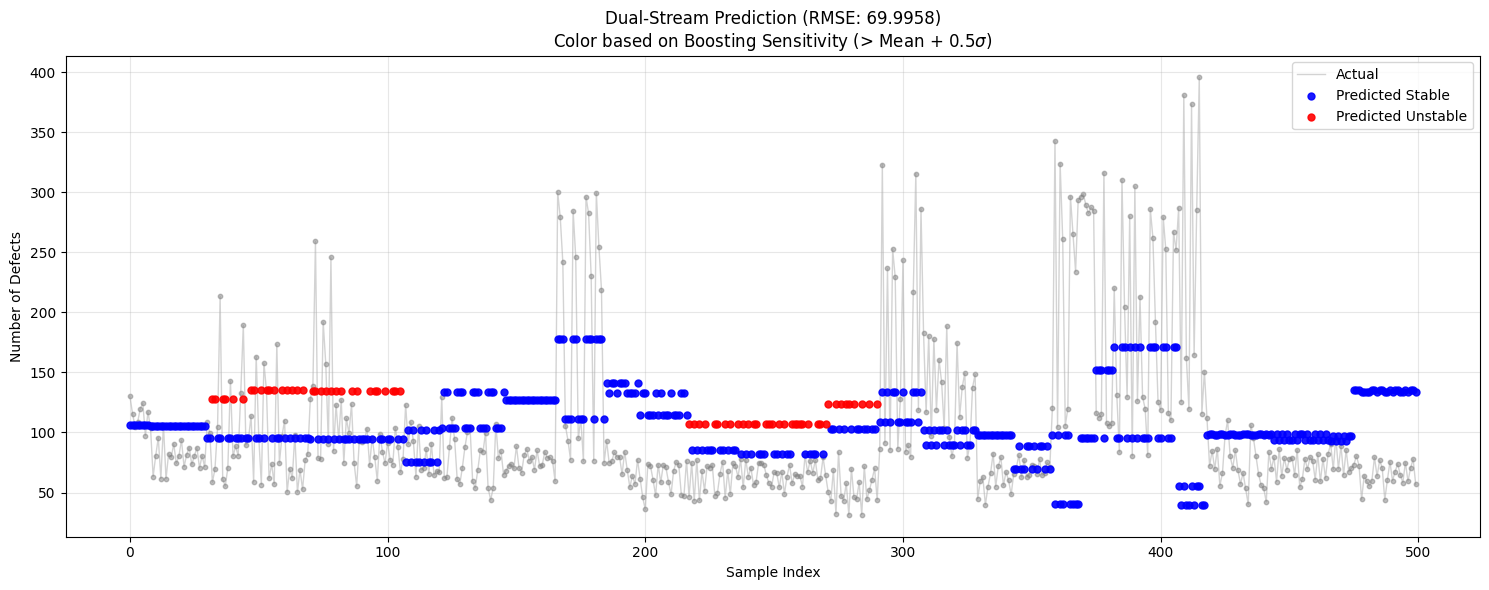

In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from collections import Counter

# -----------------------------------------------------------------------------
# 1. 前処理
# -----------------------------------------------------------------------------
dat1["process_end_time"] = pd.to_datetime(dat1["process_end_time"])
dat1["final_mes_time"] = pd.to_datetime(dat1["final_mes_time"])

# -----------------------------------------------------------------------------
# 2. 設定
# -----------------------------------------------------------------------------
N_FEATURES = 12          # 変数選択数
THRESHOLD_SIGMA = 0.5    # 判定閾値 (平均 + 0.5σ)

# アンサンブルの重み
# 不安定期の追従性を上げるため、GBの比率を少し高める
W_GLM = 0.6
W_GB  = 0.4

yHat = []
actuals = []
colors = []
used_features_history = []

print("Start prediction loop (Dual-Stream Strategy)...")

# -----------------------------------------------------------------------------
# 3. 予測ループ
# -----------------------------------------------------------------------------
for i in np.arange(1776, 2276):
    
    # --- データ分割 ---
    learn = dat1[0:i].copy().reset_index(drop=True)
    test = dat1[i:i+1].copy().reset_index(drop=True)
    
    # 時系列リーク防止
    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    if len(learn) < 50:
        val = dat1['OV'].mean()
        yHat.append(val)
        actuals.append(test.OV.values[0])
        colors.append('gray')
        continue

    X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
    Y_l = learn.OV
    X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
    Y_t = test.OV
    
    # --- Step 1: 変数選択 (Random Forest) ---
    selector = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
    selector.fit(X_l, Y_l)
    
    importances = pd.Series(selector.feature_importances_, index=X_l.columns)
    top_features = importances.nlargest(N_FEATURES).index.tolist()
    used_features_history.append(top_features)
    
    X_l_sel = X_l[top_features]
    X_t_sel = X_t[top_features]
    
    # --- Step 2: 個別モデル予測 ---
    
    # Model A: GLM (Poisson) - 安定性担当
    # 前処理: 標準化
    scaler = StandardScaler()
    X_l_std = scaler.fit_transform(X_l_sel)
    X_t_std = scaler.transform(X_t_sel)
    X_l_glm = sm.add_constant(X_l_std)
    X_t_glm = sm.add_constant(X_t_std, has_constant='add')
    
    pred_glm = 0
    try:
        model_a = sm.GLM(Y_l, X_l_glm, family=sm.families.Poisson())
        res_a = model_a.fit()
        raw_glm = res_a.predict(X_t_glm)[0]
        if np.isfinite(raw_glm):
            pred_glm = raw_glm
        else:
            pred_glm = Y_l.mean()
    except:
        pred_glm = Y_l.mean()

    # Model B: HistGradientBoosting (Poisson) - 変動検知担当
    # ★ここがポイント: このモデルは「判定」にも使われるため、感度良く学習させる
    pred_gb = 0
    try:
        model_b = HistGradientBoostingRegressor(
            loss='poisson',
            learning_rate=0.05,
            max_depth=5,
            max_iter=150, # 収束を確実にするため少し増やす
            l2_regularization=1.0,
            random_state=42
        )
        model_b.fit(X_l_sel, Y_l)
        pred_gb = model_b.predict(X_t_sel)[0]
    except:
        pred_gb = Y_l.mean()
        
    # --- Step 3: 色分け判定 (判定専用ロジック) ---
    # ★重要: アンサンブル結果ではなく、「感度の高いGB単体の予測値」で判定する
    # これにより、スパイクの予兆を見逃さず「赤」にできる
    limit_val = Y_l.mean() + THRESHOLD_SIGMA * Y_l.std()
    
    if pred_gb > limit_val:
        current_color = 'red'     # GBが「高い」と言えば、迷わず赤判定
    else:
        current_color = 'blue'

    # --- Step 4: 最終予測値算出 (RMSE最小化ロジック) ---
    # 判定結果に関わらず、予測値自体はアンサンブルで安定させる
    final_pred = W_GLM * pred_glm + W_GB * pred_gb
    
    # 上限ガード (Capping)
    max_limit = Y_l.max() * 1.2
    if final_pred > max_limit:
        final_pred = max_limit
        
    yHat.append(final_pred)
    actuals.append(Y_t.values[0])
    colors.append(current_color)

# -----------------------------------------------------------------------------
# 結果出力
# -----------------------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(actuals, yHat))
print("Prediction Complete.")
print(f"RMSE: {rmse:.4f}")

# 判定内訳
c_counts = Counter(colors)
print("\n--- Prediction Classification ---")
print(f"Predicted Stable (Blue): {c_counts['blue']} samples")
print(f"Predicted Unstable (Red): {c_counts['red']} samples")

# 変数頻度
all_feats = [f for sublist in used_features_history for f in sublist]
feat_counts = Counter(all_feats)
print("\n--- Most Frequently Used Variables (Top 5) ---")
for f, c in feat_counts.most_common(5):
    print(f"{f}: used {c} times")

print(f"\n--- Variables Used in the Last Prediction ---")
print(used_features_history[-1])

# -----------------------------------------------------------------------------
# プロット作成
# -----------------------------------------------------------------------------
plt.figure(figsize=(15, 6))

# 実測値
plt.plot(np.arange(len(actuals)), actuals, color='lightgray', linewidth=1, label='Actual', zorder=1)
plt.scatter(np.arange(len(actuals)), actuals, color='gray', s=10, alpha=0.5, zorder=1)

# 予測値（色分け）
x_idx = np.arange(len(yHat))
y_vals = np.array(yHat)
c_vals = np.array(colors)

# Stable (Blue)
mask_b = c_vals == 'blue'
if np.any(mask_b):
    plt.scatter(x_idx[mask_b], y_vals[mask_b], color='blue', label='Predicted Stable', s=25, alpha=0.9, zorder=2)

# Unstable (Red)
mask_r = c_vals == 'red'
if np.any(mask_r):
    plt.scatter(x_idx[mask_r], y_vals[mask_r], color='red', label='Predicted Unstable', s=25, alpha=0.9, zorder=3)

plt.title(f'Dual-Stream Prediction (RMSE: {rmse:.4f})\nColor based on Boosting Sensitivity (> Mean + {THRESHOLD_SIGMA}$\sigma$)')
plt.xlabel('Sample Index')
plt.ylabel('Number of Defects')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('prediction_dual_stream.png')
print("\nPlot saved as 'prediction_dual_stream.png'")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plot
from sklearn.metrics import mean_squared_error

df = pd.read_excel('kadai.xlsx')

df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"]   = pd.to_datetime(df["final_mes_time"])

yHat = []

pred = np.nan

for i in np.arange(1776, 2276):
    learn = df[:i]
    test  = df[i:i+1]

    learn = learn.reset_index(drop=True)
    test  = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
    X_t = sm.add_constant(X_t, has_constant='add')

    # 1. X30<=2.05かつX14<=42.68
    learn1 = learn[learn['X30'] <= 2.05]
    learn1 = learn1[learn1['X14'] <= 42.68]
    if len(learn1) > 0:
        l1_x = learn1.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
        l1_y = learn1.OV
        sm_l1_x = sm.add_constant(l1_x, has_constant='add')
        model1 = sm.GLM(l1_y, sm_l1_x, family=sm.families.Poisson())
        res1 = model1.fit()
    else:
        res1 = None
    
    # 2. X30<=2.05かつX14>42.68
    learn2 = learn[learn['X30'] <= 2.05]
    learn2 = learn2[learn2['X14'] > 42.68]
    if len(learn2) > 0:
        l2_x = learn2.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
        l2_y = learn2.OV
        sm_l2_x = sm.add_constant(l2_x, has_constant='add')
        model2 = sm.GLM(l2_y, sm_l2_x, family=sm.families.Poisson())
        res2 = model2.fit()
    else:
        res2 = None

    # 3. X30>2.05かつX83<=0
    learn3 = learn[learn['X30'] > 2.05]
    learn3 = learn3[learn3['X83'] <= 0]
    if len(learn3) > 0:
        l3_x = learn3.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
        l3_y = learn3.OV
        sm_l3_x = sm.add_constant(l3_x, has_constant='add') # 修正
        model3 = sm.GLM(l3_y, sm_l3_x, family=sm.families.Poisson())
        res3 = model3.fit()
    else:
        res3 = None

    # 4. X30>2.05かつX83>0
    learn4 = learn[learn['X30'] > 2.05]
    learn4 = learn4[learn4['X83'] > 0]
    if len(learn4) > 0:
        l4_x = learn4.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
        l4_y = learn4.OV
        sm_l4_x = sm.add_constant(l4_x, has_constant='add')
        model4 = sm.GLM(l4_y, sm_l4_x, family=sm.families.Poisson())
        res4 = model4.fit()
    else:
        res4 = None

    val_X30 = test['X30'].values[0]
    val_X14 = test['X14'].values[0]
    val_X83 = test['X83'].values[0]
    
    if val_X30 <= 2.05 and val_X14 <= 42.68:
        if res1 is not None: pred = res1.predict(X_t)
    elif val_X30 <= 2.05 and val_X14 > 42.68:
        if res2 is not None: pred = res2.predict(X_t)
    elif val_X30 > 2.05 and val_X83 <= 0:
        if res3 is not None: pred = res3.predict(X_t)
    elif val_X30 > 2.05 and val_X83 > 0:
        if res4 is not None: pred = res4.predict(X_t)
        
    yHat.append(pred)

Y_t = df['OV'][1776:2276]
Y_t = Y_t.reset_index()['OV']

yh = []
for y in yHat:
    if hasattr(y, 'values'):
        yh.append(y.values[0])
    elif hasattr(y, '__iter__'):
        yh.append(y[0])
    else: 
        yh.append(y)
yh = np.array(yh)

yh = np.nan_to_num(yh) 

plot.plot(Y_t)
plot.plot(yh, linestyle='-')
plot.show()

print("RMSE:")
print(np.sqrt(mean_squared_error(Y_t, yh)))